# Определение перспективного тарифа для телеком-компании «Мегалайн»

Федеральный оператор сотовой связи «Мегалайн» предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Задача — сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

### Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
  * минута разговора: 3 рубля
  * сообщение: 3 рубля
  * 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
  * минута разговора: 1 рубль
  * сообщение: 1 рубль
  * 1 Гб интернет-трафика: 150 рублей

**Примечание:** «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Содержание<a name="Содержание"></a>

1. [Знакомство с данными](#1.-Знакомство-с-данными)
2. [Подготовка данных](#2.-Подготовка-данных)
	1. [Удаление несостоявшихся звонков и интернет-сессий](#Удаление-несостоявшихся-звонков-и-интернет-сессий)
	2. [Округление длительности звонков и объема трафика](#Округление-длительности-звонков-и-объема-трафика)
	3. [Замена типа данных](#Замена-типа-данных)
	4. [Обработка дубликатов](#Обработка-дубликатов)
	5. [Обогащение данных](#Обогащение-данных)
        1. [Подсчет израсходованных минут, сообщений и интернет-трафика по мясацам для каждого пользователя](#Подсчет-израсходованных-минут,-сообщений-и-интернет-трафика-по-мясацам-для-каждого-пользователя)
        2. [Расчет услуг, использованных сверх тарифных пакетов](#Расчет-услуг,-использованных-сверх-тарифных-пакетов)
        3. [Расчет помесячной выручки с клиента](#Расчет-помесячной-выручки-с-клиента)
3. [Анализ данных](#3.-Анализ-данных)
	1. [Расход минут разговора в месяц](#Расход-минут-разговора-в-месяц)
	2. [Месячный расход сообщений](#Месячный-расход-сообщений)
	3. [Объем используемого интернет-трафика в месяц](#Объем-используемого-интернет-трафика-в-месяц)
	4. [Месячная выручка](#Выручка)
4. [Проверка гипотез](#4.-Проверка-гипотез)
	1. [Различается ли средняя выручка с пользователей тарифов «Ультра» и «Смарт»](#Различается-ли-средняя-выручка-с-пользователей-тарифов-«Ультра»-и-«Смарт»)
	2. [Отличается ли средняя выручка с пользователей из Москвы от выручки с пользователей из других регионов](#Отличается-ли-средняя-выручка-с-пользователей-из-Москвы-от-выручки-с-пользователей-из-других-регионов)
5. [Общий вывод](#6.-Общий-вывод)

## 0. Импорт библиотек<a name="0.-Импорт-библиотек"></a>

Для работы с таблицами нам нужна библиотека `pandas`. Импортируем ее. Также нам понадобится `matplotlib` для работы с графиками, некоторые математические методы из `numpy` и `scipy`. Импортируем и их.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## 1. Знакомство с данными<a name="1.-Знакомство-с-данными"></a>

Сохраним таблицы `calls`, `internet`, `messages`, `tariffs`, `users` в переменные с соответсвующими названиями.

In [3]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

Посмотрим на общую информацию о каждом датафрейме. Чтобы не копипастить, создадим функцию `show_df_description`. С ее помощью описание датафреймов можно будет вывести одной строчкой кода.

In [4]:
def show_df_description(df, statistics=True, n_samples=5):
    print(df.info())
    if n_samples != 0:    
        display(df.sample(n_samples))
    if statistics == True: 
        display(df.describe())    

### Звонки

Таблица `calls` содержит следующие данные:

- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

In [5]:
show_df_description(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
199768,1492_79,2018-12-23,3.92,1492
87447,1219_216,2018-03-26,4.73,1219
134271,1344_88,2018-09-06,0.00,1344
119883,1310_78,2018-09-09,14.11,1310
30692,1078_36,2018-07-14,12.91,1078


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


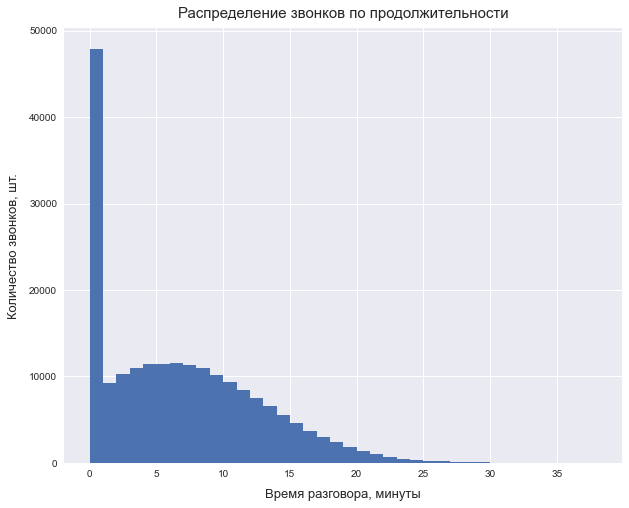

In [6]:
calls.hist('duration', bins=38, figsize=(10, 8))
plt.title('Распределение звонков по продолжительности', fontsize=15, pad=10)
plt.xlabel('Время разговора, минуты', fontsize=13, labelpad=10)
plt.ylabel('Количество звонков, шт.', fontsize=13, labelpad=10)
init_calls_hist = plt.gcf()

#### Наблюдения

- В таблице нет пропусков
- У дат в `call_date` неправильный тип данных. Должен быть `datetime` вместо строки.
- Почти 50 тысяч звонков продолжительностью 0 минут — это странно

Скорее всего, «нулевые» вызовы — это звонки, на которые не ответили.

Такие записи искажают два показателя: количество звонков клиента и структурные характеристики положения данных. Искажение суммы звонков некритично: на выручку «Мегалайна» влияет не количество разговоров, а их длительность. А она из-за записей с нулевой продолжительностью не меняется.

Зато меняется распределение длительности звонков. И хотя этот показатель не нужен в нашем исследовании, он может пригодиться позже. В общем, лучше избавиться от строчек с несостоявшимися разговорами.

### Интернет

Таблица `internet` содержит следующие данные:

- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

In [7]:
show_df_description(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
29356,29356,1102_230,123.92,2018-09-13,1102
40351,40351,1142_432,740.97,2018-04-23,1142
64326,64326,1219_233,327.40,2018-02-07,1219
29142,29142,1102_16,0.00,2018-08-14,1102
119025,119025,1402_60,563.86,2018-12-28,1402


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


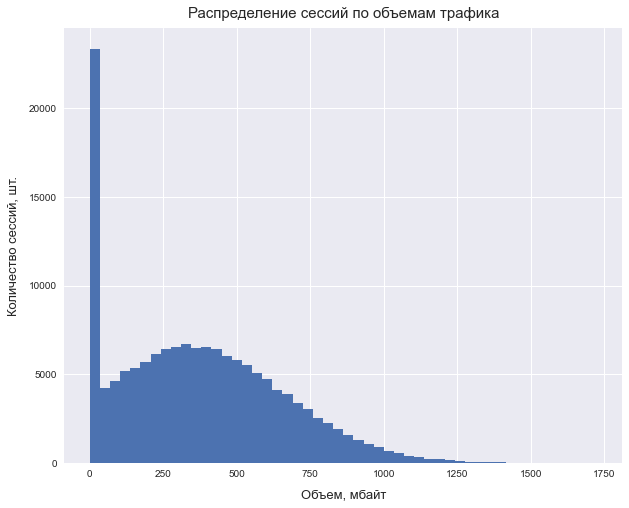

In [8]:
internet.hist('mb_used', bins=50, figsize=(10, 8))
plt.title('Распределение сессий по объемам трафика', fontsize=15, pad=10)
plt.xlabel('Объем, мбайт', fontsize=13, labelpad=10)
plt.ylabel('Количество сессий, шт.', fontsize=13, labelpad=10)
init_internet_hist = plt.gcf()

#### Наблюдения

- В таблице нет пропусков
- У дат в `session_date` неправильный тип данных. Должен быть `datetime` вместо строки.
- Столбец `Unnamed: 0` дублирует индексы строчек. Избавимся от него на этапе предобработки.
- Почти 30 тысяч несостоявшихся сессий (объем переданного трафика — 0 мегабайт). Так же, как и звонки, удалим их.

### Сообщения

Таблица `messages` содержит следующие данные:

- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

У сообщений нет свойств, для которых можно вывести статистику. Поэтому укажем в функции `show_df_description`, что статистика нам не нужна, добавив в вызов `statistics=False`.

In [9]:
show_df_description(messages, statistics=False) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
37469,1164_138,2018-10-06,1164
76314,1323_317,2018-08-13,1323
99567,1407_71,2018-08-15,1407
35394,1150_574,2018-08-09,1150
251,1000_251,2018-11-28,1000


#### Наблюдения

- В таблице нет пропусков
- У дат в `message_date` неправильный тип данных. Должен быть `datetime` вместо строки.

### Пользователи

Таблица `users` содержит следующие данные:

- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

In [10]:
show_df_description(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
345,1345,31,NaN,Москва,Галина,Ёркина,2018-06-01,smart
430,1430,22,NaN,Тверь,Андрей,Авроров,2018-04-23,ultra
220,1220,59,NaN,Ростов-на-Дону,Рубен,Астапов,2018-11-22,smart
99,1099,67,NaN,Тольятти,Аюна,Сергеева,2018-03-16,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


#### Наблюдения

- В столбце `churn_date` полно пропусков: в нем всего 38 непустых значений. Но это хорошо: значит, от «Мегалайна» ушли всего 38 клиентов.
- У дат в `reg_date` неправильный тип данных. Должен быть `datetime` вместо строки.

### Тарифы

В таблице `tariffs` хранятся описания тарифов. Не будем подробно описывать ее, потому что из нее и так все понятно. 

In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

После первичного знакомства данные кажутся качественными. Мы нашли всего три проблемы:
- во всех таблицах неправильный тип данных у дат,
- в `internet` столбец `Unnamed: 0` дублирует индексы строчек. Избавимся от него на предобработке;
- в `calls` и `internet` есть звонки и сеансы, которые, скорее всего, фактически не состоялись. Также избавимся от них.

[К содержанию](#Содержание)

## 2. Подготовка данных<a name="2.-Подготовка-данных"></a>

Начнем подготовку данных с исправления проблем, которые мы нашли при знакомстве с данными.

### Удаление несостоявшихся звонков и интернет-сессий<a name="Удаление-несостоявшихся-звонков-и-интернет-сессий"></a>

Сразу после удаления строк будем проверять, что оно прошло успешно.

In [12]:
calls = calls.drop(calls[calls['duration'] == 0].index).reset_index(drop = True)
calls[calls['duration']==0].count()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [13]:
internet = internet.drop(internet[internet['mb_used'] == 0].index).reset_index(drop = True)
internet[internet['mb_used']==0].count()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Здесь же избавимся от столбца `Unnamed: 0` в `internet`, который дублирует индексы таблицы.

In [14]:
internet = internet.drop(['Unnamed: 0'], axis='columns')
internet.sample(5)

,id,mb_used,session_date,user_id
95720,1375_175,656.62,2018-09-07,1375
75079,1294_176,1143.88,2018-07-01,1294
84306,1328_151,755.25,2018-12-19,1328
83383,1325_202,842.55,2018-07-19,1325
63148,1247_209,357.81,2018-11-05,1247


### Округление длительности звонков и объема трафика<a name="Округление-длительности-звонков-и-объема-трафика"></a>

«Мегалайн» при подсчете использованных минут и мегабайтов округляет значения вверх. Округлим и наши данные.

In [15]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls.sample(5)

,id,call_date,duration,user_id
54857,1172_431,2018-06-05,3.0,1172
40513,1126_1,2018-11-11,15.0,1126
14714,1049_720,2018-08-02,9.0,1049
100302,1321_268,2018-10-13,4.0,1321
87024,1280_242,2018-09-16,8.0,1280


In [16]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.sample(5)

,id,mb_used,session_date,user_id
88361,1341_294,407.0,2018-07-07,1341
64302,1251_109,479.0,2018-10-26,1251
28586,1116_242,150.0,2018-07-25,1116
80294,1314_238,1150.0,2018-07-21,1314
27516,1111_77,341.0,2018-12-05,1111


### Замена типа данных<a name="Замена-типа-данных"></a>

Теперь приведем данные к нужным типам. А именно:

In [17]:
calls_type_dict = {
    'id': 'object',
    'duration': 'uint8',
    'user_id': 'uint16'
}

internet_type_dict = {
    'id': 'object',
    'mb_used': 'uint16',
    'user_id': 'uint16'
}

messages_type_dict = {
    'id': 'object',
    'user_id': 'uint16'
}

users_type_dict = {
    'user_id': 'uint16',
    'age': 'uint8',
    'city': 'object',
    'first_name': 'object',
    'last_name': 'object',
    'tariff': 'object',
}

In [18]:
calls = calls.astype(calls_type_dict, errors = 'ignore')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

internet = internet.astype(internet_type_dict, errors = 'ignore')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

messages = messages.astype(messages_type_dict, errors = 'ignore')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

users = users.astype(users_type_dict, errors = 'ignore')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Проверим, как прошли преобразования.

In [19]:
def print_dtypes(df, heading):
    print('\033[1m' + heading + '\033[0m')
    display(df.dtypes)
    print()

In [20]:
print_dtypes(calls, 'Звонки')
print_dtypes(internet, 'Интернет')
print_dtypes(messages, 'Сообщения')
print_dtypes(users, 'Пользователи')

Звонки


id                   object
call_date    datetime64[ns]
duration              uint8
user_id              uint16
dtype: object


Интернет


id                      object
mb_used                 uint16
session_date    datetime64[ns]
user_id                 uint16
dtype: object


Сообщения


id                      object
message_date    datetime64[ns]
user_id                 uint16
dtype: object


Пользователи


user_id               uint16
age                    uint8
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

Все получилось так, как мы хотели, — теперь у всех данных правильные типы! Двигаемся дальше — к поиску дубликатов.

### Обработка дубликатов<a name="Обработка-дубликатов"></a>

Посмотрим, есть ли дубликаты в таблицах со звонками, сообщениями и использованным интернетом. В них нет строковых данных, а значит, число дубликатов можно вычислить, просто применив к датафреймам методы `duplicated()` и `sum()`.

In [21]:
print('\033[1m' + 'Число дубликатов' + '\033[0m')
print('Звонки:', calls.duplicated().sum())
print('Сообщения:', messages.duplicated().sum())
print('Интернет:', internet.duplicated().sum())

Число дубликатов
Звонки: 0
Сообщения: 0
Интернет: 0


Супер, в датафреймах `calls`, `messages` и `internet` дубликатов нет. Переходим к клиентам.

Датафрейм `users` обработаем по следующей схеме:
1. Сохраним столбцы `city`, `first_name` и `last_name` в соответствующие переменные.
2. Приведем эти столбцы в датафрейме к нижнему регистру.
3. Заменим все «ё» на «е».
4. Проверим, есть ли в преобразованном датафрейме дубликаты. Если есть, удалим строчки с ними.
5. Присвоим столбцам `city`, `first_name` и `last_name` значения соответсвующих переменных.
6. Сбросим индексы датафрейма, если окажется, что в нем были дубликаты.

Пункты 2 и 3 нужны, чтобы исключить ошибки ввода. А 1 и 5 — чтобы имена собственные оставались опрятными с заглавными буквами 🙂

In [22]:
#1 
initial_city = users['city'].copy()
initial_first_name = users['first_name'].copy()
initial_last_name = users['last_name'].copy()

#2
users['city'] = users['city'].str.lower()
users['first_name'] = users['first_name'].str.lower()
users['last_name'] = users['last_name'].str.lower()

#3
def fix_yo(string):
    fixed_name = ''
    
    for symbol in string:
        if symbol == 'ё':
            fixed_name += 'е'   
        else:
            fixed_name += symbol
    return fixed_name
    
users['city'] = users['city'].apply(fix_yo)
users['first_name'] = users['first_name'].apply(fix_yo)
users['last_name'] = users['last_name'].apply(fix_yo)

#4
users.duplicated().sum()

0

Оказалось, что и в таблице с пользователями дубликатов нет.

In [23]:
#5
users['city'] = initial_city
users['first_name'] = initial_first_name
users['last_name'] = initial_last_name

Теперь, когда предобработка закончена, перейдем к расчету нужных параметров.

### Обогащение данных<a name="Обогащение-данных"></a>

Для найдем:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку.

#### Подсчет израсходованных минут, сообщений и интернет-трафика по мясацам для каждого пользователя<a name="Подсчет-израсходованных-минут,-сообщений-и-интернет-трафика-по-мясацам-для-каждого-пользователя"></a>

Для первых трех задач нам подойдет простая сводная таблица.

1. Сгруппируем данные из `calls`, `messages` и `internet` по месяцам и клиентам, а в качестве значений будем использовать интересующие параметры.
2. Применим к ним функции `count` и `sum`.
3. Также сразу заменим автоматически выданные названия строчек и столбцов на более понятные.

In [24]:
calls_stats_by_users = calls.pivot_table(index=[calls['call_date'].dt.month, calls['user_id']],
                                      values='duration', aggfunc=['count', 'sum'])
calls_stats_by_users.index.names = ['month', 'user_id']
calls_stats_by_users.columns = ['calls_count', 'calls_duration_sum']
calls_stats_by_users.sample(5)

,,calls_count,calls_duration_sum
month,user_id,,
12,1314,53,483.0
9,1164,36,281.0
11,1280,68,603.0
7,1002,21,214.0
6,1340,55,535.0


In [25]:
msgs_by_users = messages.pivot_table(index=[messages['message_date'].dt.month, messages['user_id']],
                                           values='id', aggfunc='count')
msgs_by_users.index.names = ['month', 'user_id']
msgs_by_users.columns = ['messages_count']
msgs_by_users.sample(5)

,,messages_count
month,user_id,
5,1067,73
7,1172,5
10,1023,16
2,1433,85
5,1045,55


In [26]:
internet_usage_by_users = internet.pivot_table(index=[internet['session_date'].dt.month, internet['user_id']],
                                            values='mb_used', aggfunc='sum')
internet_usage_by_users.index.names = ['month', 'user_id']
internet_usage_by_users.columns = ['mb_used_sum']
internet_usage_by_users.sample(5)

,,mb_used_sum
month,user_id,
10,1350,24538
8,1144,15483
10,1298,22354
3,1468,5772
8,1266,16439


#### Объединение данных в одну таблицу

Чтобы посчитать помесячную выручку с каждого клиента, нам понадобятся данные из таблиц `users` и `tariffs`, а также из свободных таблиц, которые мы получили на прошлом шаге. Объединим их все в один большой датафрейм следующим образом:

1. Объединим сводные таблицы со звонками, сообщениями и интернетом в одну `monthly_services_usage_by_users`. Это легко сделать с помощью метода `join()`, так как у них одинаковые мультииндексы. Атрибут `how` укажем как `'outer'` — так пользователи сообщений и интернета, которые не совершали звонков, не потеряются.
2. Сбросим мультииндексы до обычных, как у других таблиц.
3. Объединим таблицы `users` и `tariffs` по столбцам `tariff` и `tariff_name` соответтвенно. Сохраним результат в переменную `users_tariffs`.
4. Избавимся от столбца `tariff_name`, так как он дублирует `tariff`.
5. Объединим `users_tariffs` и `monthly_services_usage_by_users` по столбцу `user_id` и назовем получившуюся таблицу `full_data`.

In [27]:
# 1, 2
monthly_services_usage_by_users = (calls_stats_by_users
                                   .join([msgs_by_users, internet_usage_by_users], how='outer')
                                   .reset_index())

monthly_services_usage_by_users.sample(5)

,month,user_id,calls_count,calls_duration_sum,messages_count,mb_used_sum
2005,10,1166,47.0,425.0,115.0,13695.0
801,6,1375,105.0,1045.0,72.0,20343.0
668,6,1098,14.0,101.0,5.0,8261.0
1827,9,1439,54.0,487.0,10.0,28670.0
1023,7,1269,14.0,145.0,14.0,9861.0


In [28]:
# 3, 4
users_tariffs = (users
                 .merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')
                 .drop('tariff_name', axis='columns'))

users_tariffs.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
225,1225,71,NaT,Оренбург,Даниэла,Горбачева,2018-04-26,ultra,1000,30720,3000,1950,150,1,1
83,1083,24,NaT,Сочи,Рустэм,Галкин,2018-04-24,smart,50,15360,500,550,200,3,3
415,1415,41,NaT,Москва,Андрей,Лукин,2018-06-29,ultra,1000,30720,3000,1950,150,1,1
112,1112,51,NaT,Ульяновск,Арнольд,Казанцев,2018-09-04,smart,50,15360,500,550,200,3,3
86,1086,73,NaT,Волгоград,Ириней,Аксёнов,2018-04-26,smart,50,15360,500,550,200,3,3


In [29]:
# 5
full_data = users_tariffs.merge(monthly_services_usage_by_users, on='user_id', how='left')

Теперь у нас есть таблица со всеми необходимыми данными для расчета выручки. Изучим ее.

In [30]:
show_df_description(full_data, statistics=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   uint16        
 1   age                    3216 non-null   uint8         
 2   churn_date             189 non-null    datetime64[ns]
 3   city                   3216 non-null   object        
 4   first_name             3216 non-null   object        
 5   last_name              3216 non-null   object        
 6   reg_date               3216 non-null   datetime64[ns]
 7   tariff                 3216 non-null   object        
 8   messages_included      3216 non-null   int64         
 9   mb_per_month_included  3216 non-null   int64         
 10  minutes_included       3216 non-null   int64         
 11  rub_monthly_fee        3216 non-null   int64         
 12  rub_per_gb             3216 non-null   int64         
 13  rub

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,calls_count,calls_duration_sum,messages_count,mb_used_sum
973,1153,59,NaT,Ульяновск,Евдокия,Одинцова,2018-10-18,smart,50,15360,500,550,200,3,3,12.0,82.0,648.0,NaN,26121.0
2061,1325,63,NaT,Новосибирск,Артём,Федосеев,2018-06-12,ultra,1000,30720,3000,1950,150,1,1,8.0,63.0,575.0,19.0,25528.0
848,1134,65,NaT,Красноярск,Марьяна,Авросимова,2018-01-16,smart,50,15360,500,550,200,3,3,3.0,46.0,461.0,57.0,20251.0
2165,1340,50,NaT,Пенза,Тимофей,Алютин,2018-01-30,smart,50,15360,500,550,200,3,3,10.0,42.0,352.0,11.0,18986.0
3152,1489,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,9.0,NaN,NaN,32.0,17232.0


**Наблюдения**

- У столбцов `month`, `calls_count`, `calls_duration_sum`, `messages_count` и `mb_used_sum` дробный тип данных, хотя в них хранятся целочисленные значения. Так получилось из-за особенностей работы агрегирующих функций. Исправим это.
- В `calls_count`, `calls_duration_sum`, `messages_count` есть пропуски. Они указывают на то, что клиент в какой-то месяц не пользовался соответсвующим типом услуг. Поэтому заполним их нулями.
- Два пропуска есть даже в столбце `month`. Это значит, что в определенный месяц клиент не пользовался никакими услугами «Мегалайна». Удалим эти строки.

In [31]:
full_data[full_data['month'].isna()==True]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,calls_count,calls_duration_sum,messages_count,mb_used_sum
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,NaN,NaN,NaN,NaN,NaN
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3,NaN,NaN,NaN,NaN,NaN


Заполним пропуски, удалим строки без месяцов и исправим типы данных.

In [32]:
services_columns = ['calls_count', 'calls_duration_sum', 'messages_count', 'mb_used_sum']
full_data[services_columns] = full_data[services_columns].fillna(0)

full_data.dropna(subset=['month'], inplace=True)
full_data = full_data.reset_index(drop=True)

full_data_type_dict = {
    'month': 'uint8',
    'calls_count': 'uint8',
    'calls_duration_sum': 'uint16',
    'messages_count': 'uint8',
    'mb_used_sum': 'uint16'
}
full_data = full_data.astype(full_data_type_dict)

In [33]:
show_df_description(full_data, statistics=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   uint16        
 1   age                    3214 non-null   uint8         
 2   churn_date             187 non-null    datetime64[ns]
 3   city                   3214 non-null   object        
 4   first_name             3214 non-null   object        
 5   last_name              3214 non-null   object        
 6   reg_date               3214 non-null   datetime64[ns]
 7   tariff                 3214 non-null   object        
 8   messages_included      3214 non-null   int64         
 9   mb_per_month_included  3214 non-null   int64         
 10  minutes_included       3214 non-null   int64         
 11  rub_monthly_fee        3214 non-null   int64         
 12  rub_per_gb             3214 non-null   int64         
 13  rub

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,calls_count,calls_duration_sum,messages_count,mb_used_sum
556,1089,19,NaT,Иркутск,Ксения,Нечаева,2018-02-24,ultra,1000,30720,3000,1950,150,1,1,2,1,5,27,2869
2455,1384,42,NaT,Нижний Новгород,Кристина,Касьянова,2018-04-27,smart,50,15360,500,550,200,3,3,11,81,673,2,18404
840,1132,24,NaT,Москва,Маргарита,Алехина,2018-09-01,smart,50,15360,500,550,200,3,3,11,63,544,0,16107
183,1028,20,NaT,Тверь,Рустем,Евсеев,2018-10-02,ultra,1000,30720,3000,1950,150,1,1,10,107,954,223,22519
2184,1344,60,NaT,Воронеж,Илзе,Игнатьева,2018-04-03,ultra,1000,30720,3000,1950,150,1,1,8,92,767,132,21121


#### Расчет услуг, использованных сверх тарифных пакетов<a name="Расчет-услуг,-использованных-сверх-тарифных-пакетов"></a>

Чтобы рассчитать месячную выручку с каждого пользователя, нужно понять, сколько допуслуг использовали клиенты каждый месяц. Это легко сделать: из суммарного расхода услуги нужно вычесть ее лимит, соответсвующий тарифу.

In [34]:
full_data['extra_minutes'] = full_data['calls_duration_sum'] - full_data['minutes_included']
full_data['extra_minutes'] = full_data['extra_minutes'].where(full_data['extra_minutes'] > 0, 0)

full_data['extra_messages'] = full_data['messages_count'] - full_data['messages_included']
full_data['extra_messages'] = full_data['extra_messages'].where(full_data['extra_messages'] > 0, 0)

full_data['extra_gbs'] = full_data['mb_used_sum'] - full_data['mb_per_month_included']
full_data['extra_gbs'] = full_data['extra_gbs'].where(full_data['extra_gbs'] > 0, 0)
full_data['extra_gbs'] = np.ceil(full_data['extra_gbs'] / 1024).astype('int')

full_data.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,calls_count,calls_duration_sum,messages_count,mb_used_sum,extra_minutes,extra_messages,extra_gbs
1677,1265,24,2018-10-04,Омск,Радим,Адамов,2018-06-24,ultra,1000,30720,3000,1950,150,1,1,7,81,752,94,38924,0,0,9
473,1075,25,NaT,Екатеринбург,Рафаэль,Никулин,2018-11-02,smart,50,15360,500,550,200,3,3,12,52,532,21,16886,32,0,2
1481,1231,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,1000,30720,3000,1950,150,1,1,12,0,0,191,32481,0,0,2
960,1152,44,NaT,Мурманск,Марина,Щербакова,2018-02-05,ultra,1000,30720,3000,1950,150,1,1,3,40,389,0,24775,0,0,0
686,1108,70,NaT,Москва,Рафаил,Болдырев,2018-11-01,smart,50,15360,500,550,200,3,3,11,28,231,25,20427,0,0,5


#### Расчет помесячной выручки с клиента<a name="Расчет-помесячной-выручки-с-клиента"></a>

Теперь у нас есть таблица со всеми необходимыми данными для расчета выручки. Посчитаем ее и запишем в новый столбец `revenue`.

In [35]:
full_data['revenue'] = (full_data['rub_monthly_fee'] +
                         full_data['extra_minutes'] * full_data['rub_per_minute'] +
                         full_data['extra_messages'] * full_data['rub_per_message'] +
                         full_data['extra_gbs'] * full_data['rub_per_gb'])

full_data.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,calls_count,calls_duration_sum,messages_count,mb_used_sum,extra_minutes,extra_messages,extra_gbs,revenue
421,1066,47,NaT,Астрахань,Исак,Малахов,2018-06-24,smart,50,15360,500,550,200,3,3,6,21,184,14,4681,0,0,0,550
2780,1431,70,NaT,Уфа,Елена,Тимофеева,2018-03-16,smart,50,15360,500,550,200,3,3,7,33,299,77,21535,0,27,7,2031
3135,1484,55,NaT,Екатеринбург,Илзе,Абалдуева,2018-08-04,smart,50,15360,500,550,200,3,3,10,39,369,127,13848,0,77,0,781
291,1046,72,NaT,Тула,Екатерина,Александрова,2018-08-20,smart,50,15360,500,550,200,3,3,12,63,555,48,21873,55,0,7,2115
2517,1393,56,NaT,Краснодар,Артём,Зубков,2018-02-17,smart,50,15360,500,550,200,3,3,11,72,604,47,16178,104,0,1,1062


Все получилось!

Также рассчитаем помесячную переплату пользователей.

In [36]:
full_data['overpayment'] = full_data['revenue'] - full_data['rub_monthly_fee']
full_data['overpayment'] = full_data['overpayment'].where(full_data['overpayment'] > 0, 0)

full_data.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,calls_count,calls_duration_sum,messages_count,mb_used_sum,extra_minutes,extra_messages,extra_gbs,revenue,overpayment
2291,1363,69,NaT,Нижний Тагил,Оксана,Болдырева,2018-03-04,ultra,1000,30720,3000,1950,150,1,1,3,98,841,0,20446,0,0,0,1950,0
78,1011,44,NaT,Самара,Веселина,Алёшко,2018-03-19,smart,50,15360,500,550,200,3,3,3,19,212,4,5900,0,0,0,550,0
2049,1323,67,NaT,Челябинск,Эсмеральда,Носкова,2018-08-02,smart,50,15360,500,550,200,3,3,12,61,538,85,20921,38,35,6,1969,1419
1299,1203,39,NaT,Москва,Владимир,Григорьев,2018-03-13,ultra,1000,30720,3000,1950,150,1,1,7,56,522,38,3185,0,0,0,1950,0
1836,1290,68,NaT,Нижний Новгород,Арсений,Безруков,2018-05-11,smart,50,15360,500,550,200,3,3,10,60,520,0,19177,20,0,4,1410,860


### Вывод

Мы сделали новую таблицу `full_data`, в которой собрали параметры интересные для анализа. А именно:
* количество сделанных звонков и израсходованных минут по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку.

Для этого нам пришлось создать несколько вспомогательных сводных таблиц и написать небольшую функцию для подсчета выручки. Вооруженные новой таблицей мы готовы к анализу данных.

[К содержанию](#Содержание)

## 3. Анализ данных<a name="3.-Анализ-данных"></a>

Для каждой услуги (голосовая связь, сообщения и интернет) мы будем изучать общую статистику и распределение по объему использования. Также мы отдельно посмотрим на потребление услуг сверх тарифных пакетов. Напишем для этого вспомогательные функции:

In [37]:
def service_stats(df, service):
    """
    Функция возвращает таблицу со статистиками месячного потребления заданной услуги.
    А именно: медиану, среднее и стандартное отклонение.
    """
    pivot = df.pivot_table(index ='tariff', values=service, aggfunc=['median', 'mean', 'std'])
    return pivot

In [38]:
def extra_stats(df, service):
    """
    Функция возвращает таблицу со статистиками месячного перерасхода заданной услуги.
    А именно: как часто пользователи превышали лимит тарифа (абсолютное значение и относительное от всех клиентов с тарифом),
    медиану, среднее и стандартное отклонение.
    """
    users_by_tariff = df.groupby('tariff').agg({'user_id': ['count']})
    extra_stats = (full_data.query('{}>0'.format(extra_service))
                   .groupby('tariff').agg({service: ['count', 'median', 'mean', 'std']}))
    extra_stats = users_by_tariff.join(extra_stats).fillna(0)
    
    extra_stats[('percentage', 'count')] = ((extra_stats[(service, 'count')] / 
                                             extra_stats[('user_id', 'count')] * 100).round(2))
    extra_stats.columns = ['total_cnt', service+'_cnt', service+'_median',
                           service+'_mean',service+'_std', service+'_percentage']
    extra_stats = extra_stats[['total_cnt', service+'_cnt', service+'_percentage',
                               service+'_median', service+'_mean', service+'_std']]
    return extra_stats

In [39]:
def service_hist(df, service, title='', lims=[]):
    """
    Функция возвращает распределение использования услуги. 
    
    Параметры:
    - df — таблица, по данным из которой строится распределение,
    - service — название столбца с нужной услугой,
    - title — заголовок графика,
    - lims — лимиты на услугу для каждого тарифа, если есть.
    """
    smart = df[df['tariff']=='smart'][service]
    ultra = df[df['tariff']=='ultra'][service]
    
    plt.figure(figsize=(11, 6.5))
    plt.hist(smart, bins=50, alpha=0.6, label='Смарт')
    plt.hist(ultra, bins=50, alpha=0.6, label='Ультра', color='orange') 

    if len(lims) == 2:
        smart_lim, ultra_lim = lims
        if ultra.max() > ultra_lim:
            smart_lim, ultra_lim = lims
            plt.axvline(x=smart_lim, linewidth=3)
            plt.axvline(x=ultra_lim, linewidth=3, color='orange')
        else:
            plt.axvline(x=smart_lim, linewidth=3)
        
    plt.title(title, fontsize=16, pad=13)
    plt.legend(loc='upper right', prop={'size': 13.3})
    
    plt.gca().set_xlabel('Объем услуги', fontsize=13, labelpad=10)
    plt.gca().set_ylabel('Пользователе-месяцы', fontsize=13, labelpad=10)
    plt.gca().tick_params(axis='both', labelsize=12)
    
    ans = plt.gcf()
    plt.close()
    return ans

### Расход минут разговора в месяц<a name="Расход-минут-разговора-в-месяц"></a>

,median,mean,std
,calls_duration_sum,calls_duration_sum,calls_duration_sum
tariff,,,
smart,422,417.934948,190.313730
ultra,518,526.623350,317.606098


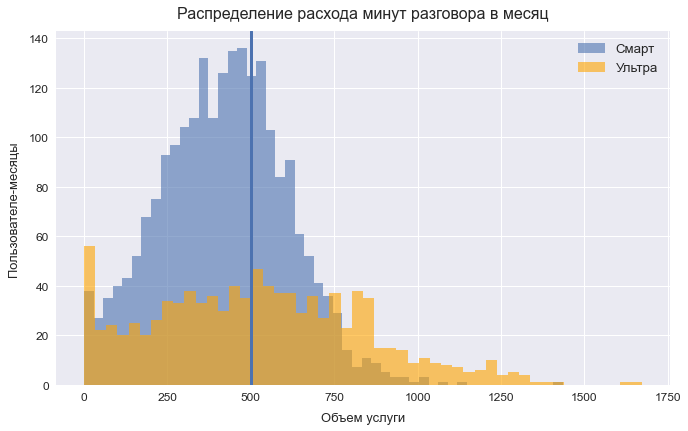

In [40]:
display(service_stats(full_data, 'calls_duration_sum'))
service_hist(full_data, 'calls_duration_sum', 'Распределение расхода минут разговора в месяц', [500, 3000])

Вертикальными прямыми разных цветов обозначены лимиты для каждого тарифа. На этом графике прямая только одна, потому что пользователи «Ультры» не выходили за пределы тарифного пакета. 

Из распределения видно, что клиенты со «Смартом» часто используют весь пакет минут и даже выходят за его пределы. Среди пользователей с «Ультрой» другая динамика: они с примерно одинаковой частотой тратят от нуля до 900 минут в месяц. Это, кстати, в три раза меньше лимита в их тарифе.

Статистики показывают, что и средний, и медианный клиент «Ультры» тратят в месяц всего на сто минут больше, чем клиент со «Смартом» — около 420 и 520 минут соответственно.

,total_cnt,extra_minutes_cnt,extra_minutes_percentage,extra_minutes_median,extra_minutes_mean,extra_minutes_std
tariff,,,,,,
smart,2229,754.0,33.83,100.0,122.996021,105.793184
ultra,985,0.0,0.00,0.0,0.000000,0.000000


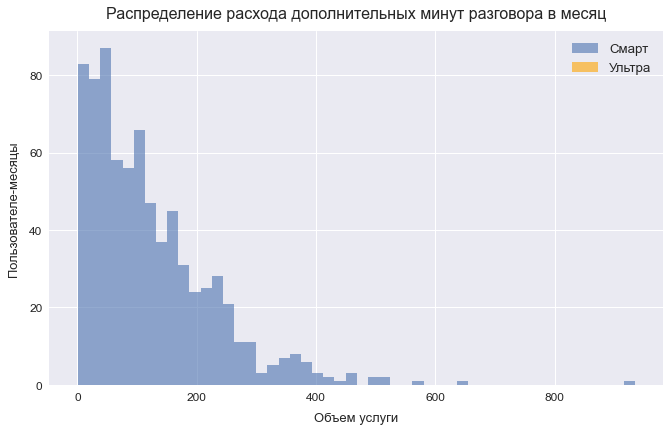

In [41]:
extra_service = 'extra_minutes'
display(extra_stats(full_data, extra_service))
service_hist(full_data.query('{}>0'.format(extra_service)), extra_service, 'Распределение расхода дополнительных минут разговора в месяц')

Клиентам со «Смартом» не хватает пакетных 500 минут разговора в 34% случаев. Чаще всего они используют до 100 дополнительных минут, а больше 300 — крайне редко.

### Месячный расход сообщений<a name="Месячный-расход-сообщений"></a>

,median,mean,std
,messages_count,messages_count,messages_count
tariff,,,
smart,28,33.384029,28.227876
ultra,38,49.363452,47.804457


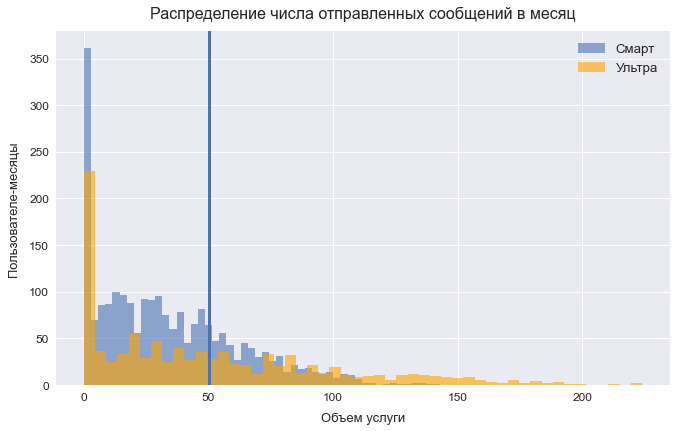

In [42]:
display(service_stats(full_data, 'messages_count'))
service_hist(full_data, 'messages_count', 'Распределение числа отправленных сообщений в месяц', [50, 1000])

На графике снова одна вертикальная прямая: ни один клиент с «Ультрой» ни разу за 2018 год не достиг тарифного лимита по отправленным сообщениям. Смски вообще не очень популярный вид связи. Об этом говорят пики у нуля, которые обозначают, что в какие-то месяцы клиенты пользовались звонками и/или интернетом, но не отправили ни одного сообщения.

,total_cnt,extra_messages_cnt,extra_messages_percentage,extra_messages_median,extra_messages_mean,extra_messages_std
tariff,,,,,,
smart,2229,564.0,25.3,18.5,22.921986,17.942308
ultra,985,0.0,0.0,0.0,0.000000,0.000000


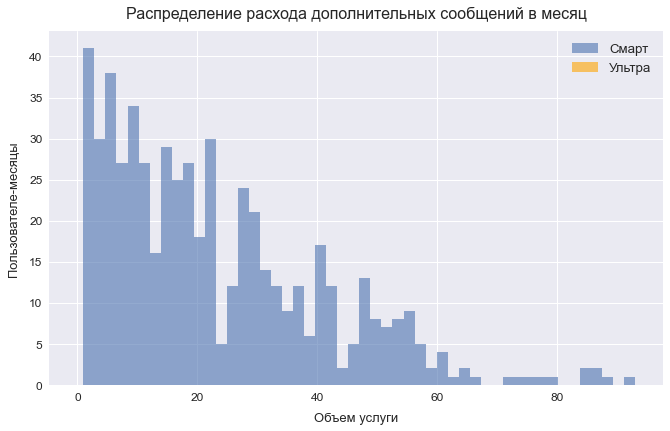

In [43]:
extra_service = 'extra_messages'
display(extra_stats(full_data, extra_service))
service_hist(full_data.query('{}>0'.format(extra_service)), extra_service, 'Распределение расхода дополнительных сообщений в месяц')

Всего в четверти случаев пользователям «Смарта» не хватило пакетных 50 смсок. Перерасход почти линейно падает от 40 раз с одной смской до 2-3 в районе 60. В среднем пользователи превышают лимит на 19–23 смски в месяц и переплачивают за это меньше ста рублей.

### Объем используемого интернет-трафика в месяц<a name="Объем-используемого-интернет-трафика-в-месяц"></a>

,median,mean,std
,mb_used_sum,mb_used_sum,mb_used_sum
tariff,,,
smart,16531,16229.188425,5877.576978
ultra,19324,19486.901523,10096.317202


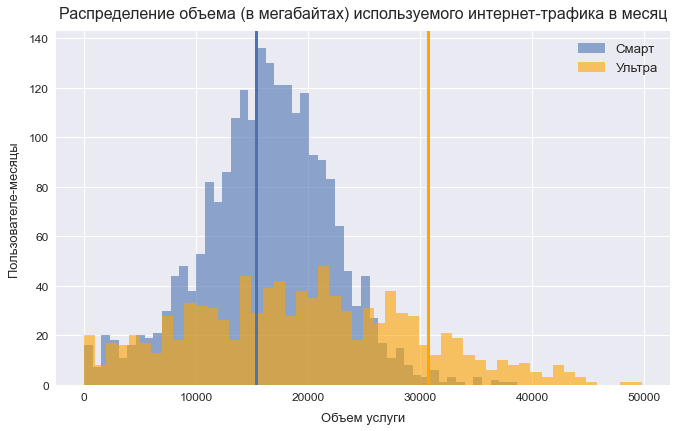

In [44]:
display(service_stats(full_data, 'mb_used_sum'))
service_hist(full_data, 'mb_used_sum', 'Распределение объема (в мегабайтах) используемого интернет-трафика в месяц', [15360, 30720])

Мобильный интернет — самая востребованная услуга. Клиентам со «Смартом» не хватает тарифного пакета в более чем в половине случаев. Пользователи «Ультры» выходят за пределы тарифа гораздо реже, но со звонками и сообщениями такого вообще не бывает.

Интересно, что среднее потребление на обоих тарифах несильно отличается. На «Смарте» — примерно 16 гигабайт в месяц, на «Ультре» — 19, что всего на 20% больше. А по условиям тарифа разница составляет 15 гигибайт в месяц, или месячный лимит «Смарта».

,total_cnt,extra_gbs_cnt,extra_gbs_percentage,extra_gbs_median,extra_gbs_mean,extra_gbs_std
tariff,,,,,,
smart,2229,1309,58.73,4,5.129106,3.523749
ultra,985,134,13.60,5,5.932836,4.067472


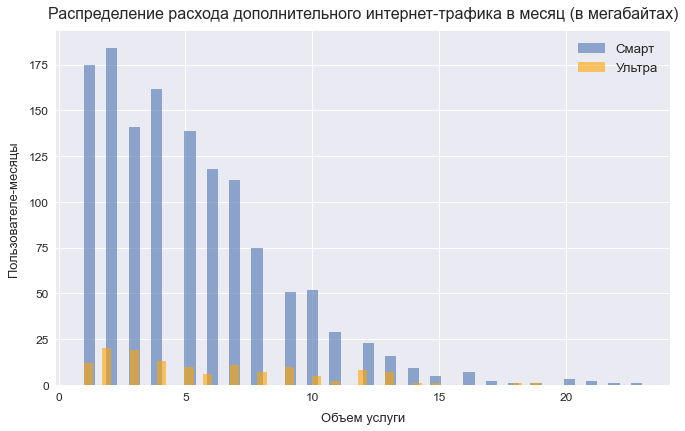

In [45]:
extra_service = 'extra_gbs'
display(extra_stats(full_data, extra_service))
service_hist(full_data.query('{}>0'.format(extra_service)), extra_service,
             'Распределение расхода дополнительного интернет-трафика в месяц (в мегабайтах)')

Клиенты с «Ультрой» используют дополнительный интернет в 14% случаев. Они примерно с одинаковой частотой расходуют от 1 до 10 допгигабайт в месяц и совсем редко тратят больше.

У пользователей «Смарта» другая динамика перерасхода трафика: чем перерасход больше, тем реже он встречается. При этом от 1 до 5 допгигабайт тратили примерно с одинаковой частотой, хотя начиная с 3 гигабайт переплата за интернет превосходит месячную абонентскую плату (600 и 550 рублей соответственно).

### Месячная выручка<a name="Выручка"></a>

In [46]:
revenue_stats = full_data.pivot_table(index ='tariff', values='revenue', aggfunc=['median', 'mean', 'std', 'sum'])
revenue_stats

,median,mean,std,sum
,revenue,revenue,revenue,revenue
tariff,,,,
smart,1038,1294.63930,820.933202,2885751
ultra,1950,2071.06599,378.802377,2040000


Интересно, что пользователи «Смарта» в половине случаев платят за связь в два раза больше месячной абонентской платы (550 рублей).

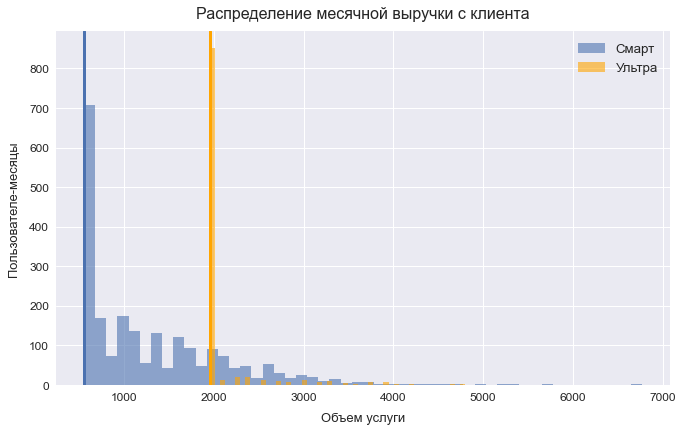

In [47]:
service_hist(full_data, 'revenue', 'Распределение месячной выручки с клиента', [550, 1950])

Из распределения видно, что клиенты со «Смартом» чаще платят за услуги больше стандартной абонентской, чем клиенты «Ультры». При этом иногда они платят даже больше, чем абонентская плата за «Ультру».

,total_cnt,overpayment_cnt,overpayment_percentage,overpayment_median,overpayment_mean,overpayment_std
tariff,,,,,,
smart,2229,1665,74.7,800,996.877477,806.692933
ultra,985,134,13.6,750,889.925373,610.120777


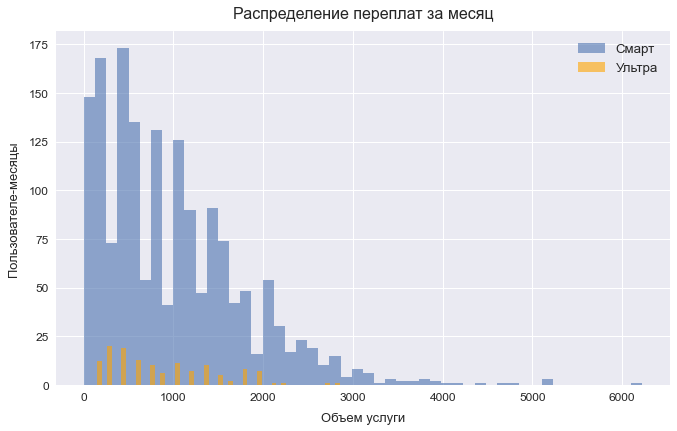

In [48]:
extra_service = 'overpayment'
display(extra_stats(full_data, extra_service))
service_hist(full_data.query('{}>0'.format(extra_service)), extra_service, 'Распределение переплат за месяц')

Интересно, что и в случае с пользователями «Смарта», и в случае с пользователями «Ультры» распределение переплат имеет ярко выраженные зубцы. Можно заметить, что они находятся у чисел кратных 200 и 150, то есть сумм равных `n * стоимость допгигабайта интернета на тарифе`.

[К содержанию](#Содержание)

## 4. Проверка гипотез<a name="4.-Проверка-гипотез"></a>

Проверим две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Различается ли средняя выручка с пользователей тарифов «Ультра» и «Смарт»<a name="Различается-ли-средняя-выручка-с-пользователей-тарифов-«Ультра»-и-«Смарт»"></a>

Начнем со средней выручки с пользователей тарифов «Ультра» и «Смарт». 

**Нулевая гипотеза:** Средняя выручка с пользователей тарифов «Ультра» равна средней выручке с пользователей тарифа «Смарт».  
**Альтернативная гипотеза:** Средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается.

Для проверки нулевой гипотезы воспользуемся методом `results = st.ttest_ind`. Укажем `equal_var = False`, потому что мне кажется, что у генеральных совокупностей, из которых взяты выборки, разные параметры распределения.

Пороговым значеним alpha сделаем 5%.

In [49]:
alpha = 0.05
results = st.ttest_ind(full_data[full_data['tariff']=='smart']['revenue'],
                       full_data[full_data['tariff']=='ultra']['revenue'],
                       equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 2.7240946993530856e-246
Отвергаем нулевую гипотезу


Имеющиеся данные указывают на то, что нулевая гипотеза, скорее всего, неверна. То есть средняя выручка с пользователей тарифов «Ультра» и «Смарт» **различается**.

Посмотрим, на каком тарифе средняя выручка больше.

In [50]:
mean_revenue_smart = round(full_data[full_data['tariff']=='smart']['revenue'].mean())
mean_revenue_ultra = round(full_data[full_data['tariff']=='ultra']['revenue'].mean())

print('\033[1m' + 'Средняя выручка с клиентов' + '\033[0m')
print('Смарт:', mean_revenue_smart)
print('Ультра:', mean_revenue_ultra)

Средняя выручка с клиентов
Смарт: 1295
Ультра: 2071


Выручка с клиентов с «Ультрой» ожидаемо больше, чем с клиентов со «Смартом».

### Отличается ли средняя выручка с пользователей из Москвы от выручки с пользователей из других регионов<a name="Отличается-ли-средняя-выручка-с-пользователей-из-Москвы-от-выручки-с-пользователей-из-других-регионов"></a>

Теперь проверим вторую гипотезу о том, что средняя выручка с пользователей из Москвы отличается от выручки с пользователей из других регионов. 

**Нулевая гипотеза:** Средняя выручка с пользователей из Москвы равна выручке с пользователей из других регионов.  
**Альтернативная гипотеза:** Средняя выручка с пользователей из Москвы и регионов различается.

Проверим нулевую гипотезу тем же образом, что и предыдущую нулевую гипотезу.

In [51]:
results = st.ttest_ind(full_data[full_data['city']=='Москва']['revenue'],
                       full_data[full_data['city']!='Москва']['revenue'],
                       equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


На этот раз данные не противоречат нулевой гипотезе. То есть средняя выручка с пользователей из Москвы **не отличается** от выручки пользователей из других регионов.

### Вывод

С помощью t-тестов, которые используют распределение Стьюдента, мы проверили две гипотезы о средней выручке с клиентов с разными тарифами и о выручки с клиентов из Москвы и регионов. Данные показали, что:
* средняя выручка с пользователей тарифов «Ультра» и «Смарт» **различается**: «Ультра» приносит больше выручки, чем «Смарт»;
* средняя выручка с пользователей из Москвы **не отличается** от выручки пользователей из других регионов.

[К содержанию](#Содержание)

## 6. Общий вывод<a name="6.-Общий-вывод"></a>

Основной задачей исследования было узнать, какой тариф приносит «Мегалайну» больше денег. Ответ — «Ультра»:

- Исходя из теста Стьюдента, в котором мы сравнили месячные выручки с пользователей «Смарта» и «Ультры», этот параметр отличается в генеральных совокупностях.
- А исходя из исследования выборок клиенты «Ультры» приносят больше денег.

Еще мы узнали, что средняя выручка с пользователей из Москвы не отличается от выручки с пользователей из других регионов.

Также в процессе исселедования мы изучили месячные траты на связь сверх абонентской платы за тариф:

,median,mean,std,sum
,revenue,revenue,revenue,revenue
tariff,,,,
smart,1038,1294.63930,820.933202,2885751
ultra,1950,2071.06599,378.802377,2040000


,total_cnt,overpayment_cnt,overpayment_percentage,overpayment_median,overpayment_mean,overpayment_std
tariff,,,,,,
smart,2229,1665,74.7,800,996.877477,806.692933
ultra,985,134,13.6,750,889.925373,610.120777


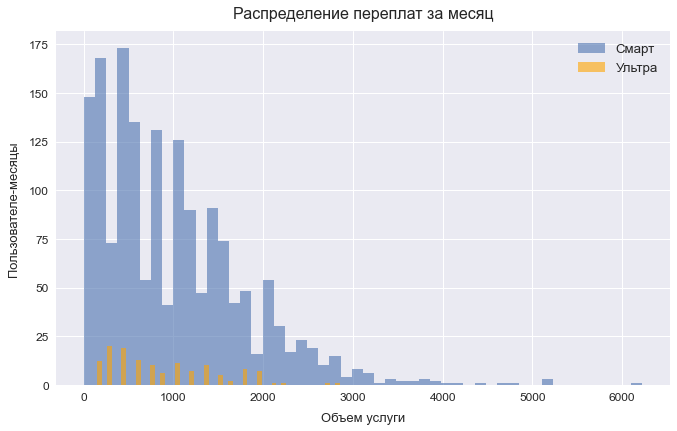

In [52]:
extra_service = 'overpayment'

display(revenue_stats)
display(extra_stats(full_data, extra_service))
service_hist(full_data.query('{}>0'.format(extra_service)), extra_service, 'Распределение переплат за месяц')

Пользователи «Смарта» платят больше абонентской платы в 75% случаев. При этом в половине случаев они доплачивают за услуги больше, чем стоит месяц пользования тарифом.

Это объясняется тем, что самая популярная услуга (причем на обоих тарифах) — это мобильный интернет. Клиентам со «Смартом» не хватает тарифного пакета больше чем в половине случаев, и они нередко расходут больше 3 гигабайт дополнительного интернета, что уже стоит больше, чем абонентская плата на их тарифе (600 и 550 рублей соответственно).

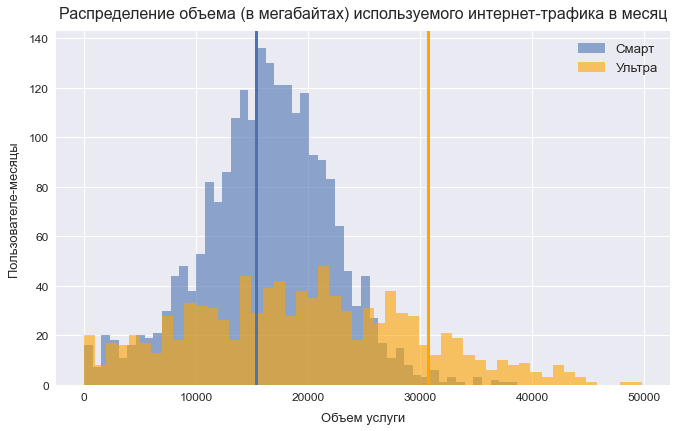

,total_cnt,extra_gbs_cnt,extra_gbs_percentage,extra_gbs_median,extra_gbs_mean,extra_gbs_std
tariff,,,,,,
smart,2229,1309,58.73,4,5.129106,3.523749
ultra,985,134,13.60,5,5.932836,4.067472


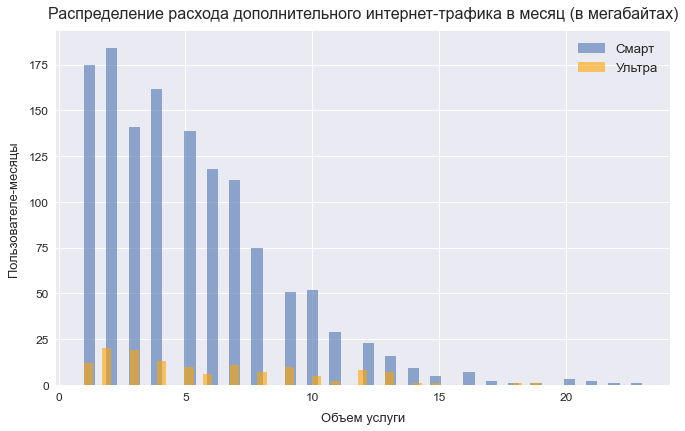

In [53]:
display(service_hist(full_data, 'mb_used_sum', 'Распределение объема (в мегабайтах) используемого интернет-трафика в месяц', [15360, 30720]))

extra_service = 'extra_gbs'
display(extra_stats(full_data, extra_service))
service_hist(full_data.query('{}>0'.format(extra_service)), extra_service,
             'Распределение расхода дополнительного интернет-трафика в месяц (в мегабайтах)')

[К содержанию](#Содержание)